### Basic Nerual Network
Followed tutioral from:
https://www.youtube.com/watch?v=VMj-3S1tku0&t=2143s&ab_channel=AndrejKarpathy

In [914]:
#Libraries to be install
import numpy as np
import math
import graphviz as gv
from graphviz import Digraph
import random

In [915]:
class perceptron:
    def __init__(self, x):
        self.value = 0.0 + x
        self.children = []
        self.parents = []

    def add_child(self, child):
        self.children.append(child)
        child.parents.append([self, random.uniform(-1,1)])

In [916]:
class nerualNetwork:
    def __init__(self, numIn, numLayers, numOut, actFunc, bias):
        self.numIn = numIn
        self.numLayers = numLayers 
        self.numOut = numOut
        self.inputs = []
        self.outputs = []
        self.actFunc = actFunc
        self.bias = bias
        self.construct()

    def construct(self):

        def connect(lstOne, lstTwo):
            for node1 in lstOne:
                for node2 in lstTwo:
                    node1.add_child(node2)
            return lstOne
            
        inputs = []
        outputs = []
        layers = []

        # Intilizing the input column
        for i in range(self.numIn):
            input1 = perceptron(self.bias)
            inputs.append(input1)

        # Intilizing the output column
        for i in range(self.numOut):
            output1 = perceptron(0)
            outputs.append(output1)

        if len(self.numLayers) == 0:
            inputs = connect(inputs, outputs)
            self.inputs = inputs
            self.outputs = outputs
        else:
            # Creating the layers
            for i, item in enumerate(self.numLayers):
                lyrIns = []
                for i in range(item):
                    input2 = perceptron(self.bias)
                    lyrIns.append(input2)
                layers.append(lyrIns)
            
            
            # Iterate through the layers in reverse order
            for i in range(len(layers) - 1, -1, -1):
                    
                # If it's the last layer, connect it to the current layer
                if i == len(layers) - 1:
                    current = layers[i]
                    current = connect(current, outputs)
                
                # If it's not the last layer, connect it to the next layer
                else:
                    next_layer = layers[i]
                    next_layer = connect(next_layer, current)
                    current = next_layer

            # Finally, connect the input layer to the current layer
            inputs = connect(inputs, current)
            
            self.inputs = inputs
            self.outputs = outputs

    def forwardProp(self, inpts):
        for i in range(len(self.inputs)):
            self.inputs[i].value = inpts[i]
            
        def DFS_forward(node):
            # Get list of the current children
            lstChildren = node.children #[sublist[0] for sublist in node.children]
            # Print the child Val & Grad and decend back down
            for child in lstChildren:
                values = [sublist[0].value for sublist in child.parents]
                weights = [sublist[1] for sublist in child.parents]
                x = np.dot(values, weights) + self.bias
                if self.actFunc == "Sigmoid": 
                    x = 1 / (1 + np.exp(-x))
                elif self.actFunc == "ReLU":
                    x = np.maximum(0, x)
                elif self.actFunc == "Softplus":
                    x = np.log(1 + np.exp(x))
                child.value = x
                DFS_forward(child)

        for n in self.inputs:
            DFS_forward(n)
        
        return 0

    def backwardProp(self, labels, r):
            
        def DFS_backward(node, label, r, mult):
            # Get list of the current children
            pairsParents = node.parents #[sublist[0] for sublist in node.children]
            # Print the child Val & Grad and decend back down
            for pair in pairsParents:
                newWeight = 0
                a0 = node.value
                a1 = pair[0].value
                w = pair[1]
                if self.actFunc == "Sigmoid": 
                    newWeight = w - r * (a1 * (1 - a1)) * 2 * (a0 - label) + self.bias
                elif self.actFunc == "ReLU":
                    newWeight = 0
                elif self.actFunc == "Softplus":
                    newWeight = 0

                pair[1] = newWeight
                DFS_backward(pair[0],label,r,mult)

        for node, label in zip(self.outputs, labels):
            DFS_backward(node, label, r, 1.0)

    def train(self, inputs, labels, r,epochs):

        for epochs in range(epochs):
            for input, label in zip(inputs,labels):
                self.forwardProp(input)
                self.backwardProp(label,r)

    def predict(self, inputs):
        self.forwardProp(inputs)
        return [node.value for node in self.outputs]
        

In [917]:
# Graphing Function
def trace(roots):
    nodes, edges = set(), set()
    visited = set()

    def build(v):
        if v not in visited:
            visited.add(v)
            nodes.add(v)
            for child in reversed(v.children):
                edges.add((child, v))
                build(child)

    for root in roots:
        build(root)

    return nodes, edges

def draw_dot(roots):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'})  # LR = left to right

    nodes, edges = trace(roots)
    for n in nodes:
        uid = str(id(n))
        # for any value in the graph, create a rectangular ('record') node for it
        dot.node(name=uid, label="value: %.4f" % (n.value), shape='circle', width='1.0', height='1.0')
    x = 1
    for n1, n2 in edges:
        
        # connect n1 to n2
        weights1 = [sublist[1] for sublist in n1.parents]
        nodeP1 = [sublist[0] for sublist in n1.parents]
        weight = 0
        for index, parent in enumerate(nodeP1):
            if parent == n2:
                weight = weights1[index]

        edge_label = "w: %.4f" % weight
        dot.edge(str(id(n2)), str(id(n1)), label=edge_label)
        x+=1

    return dot

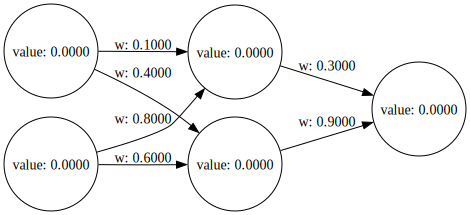

In [918]:
NN = nerualNetwork(2,[2],1,"Sigmoid",0.1)
x = 0.8
NN.inputs[0].children[0].parents[0][1] = 0.1
NN.inputs[0].children[0].parents[1][1] = 0.8
NN.inputs[0].children[1].parents[0][1] = 0.4
NN.inputs[0].children[1].parents[1][1] = 0.6
NN.inputs[0].children[0].children[0].parents[0][1] = 0.3
NN.inputs[0].children[0].children[0].parents[1][1] = 0.9
draw_dot(NN.inputs)



0


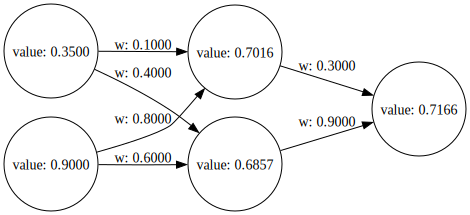

In [919]:
print(NN.forwardProp([0.35,0.9]))
draw_dot(NN.inputs)

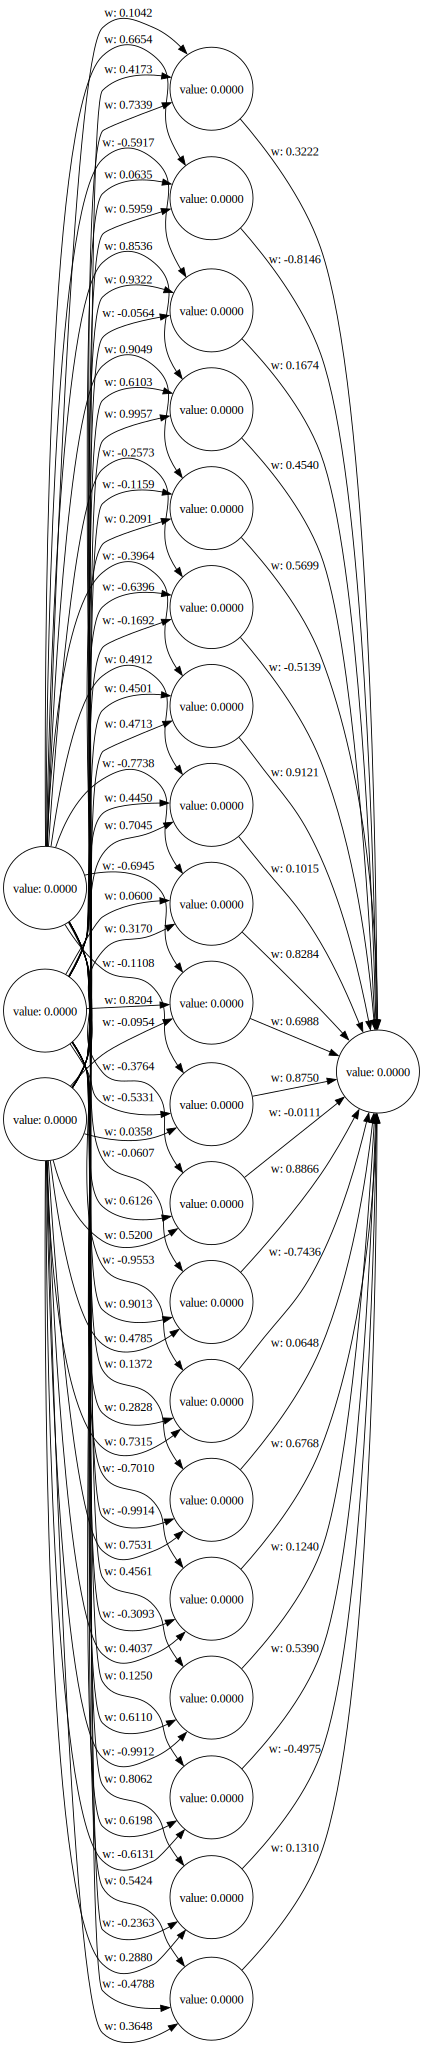

In [920]:
ANDgateModel = nerualNetwork(3,[20],1,"Sigmoid",-1)
draw_dot(ANDgateModel.inputs)

In [921]:
xs = [
  [0, 0, 0],
  [0, 0, 1],
  [0, 1, 0],
  [0, 1, 1],
  [1, 0, 0],
  [1, 0, 1],
  [1, 1, 0],
  [1, 1, 1],
]
ys = [[0],[0],[0],[1],[1],[0],[0],[1]] # desired targets

In [922]:
ANDgateModel.train(xs,ys,0.1,10000)
for i in range(len(xs)):
    print('Predict: %0.3f, TrueVal: %d'%(ANDgateModel.predict(xs[i])[0], ys[i][0]))

Predict: 0.001, TrueVal: 0
Predict: 0.034, TrueVal: 0
Predict: 0.050, TrueVal: 0
Predict: 0.508, TrueVal: 1
Predict: 0.001, TrueVal: 1
Predict: 0.657, TrueVal: 0
Predict: 0.646, TrueVal: 0
Predict: 0.989, TrueVal: 1
